# Developping the multiview dataset, datamodule, model and loss

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
from pathlib import Path
from typing import Any, Union

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torch_geometric.utils as pyg_utils
from dgl import DropNode, FeatMask, LaplacianPE, SIGNDiffusion
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf, open_dict
from torch import nn
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data

from src.models.multiview_cl.datamodule import MultiviewDataModule
from src.models.multiview_cl.dataset import MultiviewDataset
from src.models.multiview_cl.module import MultiviewModule
from src.modules.losses.multiview_losses import KLDivergenceMultiplePositives, NTXentMultiplePositives

In [3]:
for i in range(1, 4):
    if not Path(f"../cpjump{i}/jump/").exists():
        print(f"Mounting cpjump{i}...")
        os.system(f"sshfs bioclust:/projects/cpjump{i}/ ../cpjump{i}")
    else:
        print(f"cpjump{i} already mounted.")

cpjump1 already mounted.
cpjump2 already mounted.
cpjump3 already mounted.


## Check configs

In [4]:
# GlobalHydra.instance().clear()

In [4]:
initialize(version_base=None, config_path="../configs")

hydra.initialize()

In [5]:
cfg = compose(
    config_name="train.yaml",
    overrides=[
        "evaluate=false",
        "eval=none",
        "paths.projects_dir=..",
        "paths.output_dir=./tmp/21312FS12A",
        "experiment=final/loss_experiments/multiview_transform_dropout",
        "data.batch_size=4",
        "trainer.devices=1",
    ],
)
print(OmegaConf.to_yaml(cfg))

task_name: train
tags:
- final_experiments
- pretrained
- loss_experiments
- multiple_view
- med_data
- resnet34
- pna
- multiview_ntxent
train: true
load_first_bacth: true
test: true
evaluate: false
compile: false
ckpt_path: null
seed: 12345
data:
  compound_transform:
    _target_: src.modules.compound_transforms.pna.PNATransform
    compound_str_type: inchi
  transform:
    _target_: src.modules.transforms.ComplexTransform
    _convert_: object
    size: 512
    flip_p: 0.3
    drop_p: 0.15
    gaussian_p: 0.8
    color_p: 0.8
    kernel_size: 23
    sigma:
    - 1
    - 3
    intensity: 0.3
    brightness: 0.2
    use_flip: true
    use_blur: false
    use_color_jitter: true
    use_drop: true
    use_resized_crop: true
  _target_: src.models.multiview_cl.datamodule.MultiviewDataModule
  split_path: ${paths.split_path}/scaffold_split/
  train_ids_name: train_med
  n_views: 3
  batch_size: 4
  num_workers: 16
  pin_memory: null
  prefetch_factor: 2
  drop_last: true
  collate_fn: nu

In [6]:
dm = instantiate(cfg.data)

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Plea

In [7]:
dm.setup("fit")

In [8]:
dl = dm.train_dataloader()
b = next(iter(dl))

In [30]:
b["image"].shape

torch.Size([12, 3, 5, 512, 512])

In [36]:
b["compound"]

Graph(num_nodes=252, num_edges=532,
      ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)})

In [32]:
cp_tr = instantiate(cfg.data.compound_transform)

In [33]:
i_tr = instantiate(cfg.data.transform)

In [11]:
model = instantiate(cfg.model)

## Dataset

In [15]:
metadata_dir = "../cpjump1/jump/metadata"
load_data_dir = "../cpjump1/jump/load_data"
split_dir = "../cpjump1/jump/models/splits/scaffold_split"

In [16]:
os.listdir(split_dir)

['total_train.csv',
 'test.csv',
 'val.csv',
 'retrieval.csv',
 'train_med.csv',
 'train_med_compound_dict.json',
 'train_med_load_df.parquet',
 'val_compound_dict.json',
 'val_load_df.parquet',
 'test_compound_dict.json',
 'test_load_df.parquet',
 'train_big.csv',
 'train_big_compound_dict.json',
 'train_big_load_df.parquet',
 'retrieval_compound_dict.json',
 'retrieval_load_df.parquet',
 'train_small.csv',
 'train_small_compound_dict.json',
 'train_small_load_df.parquet']

In [17]:
with open(f"{split_dir}/train_small_compound_dict.json") as f:
    comp = json.load(f)

In [18]:
load_df = pd.read_parquet(f"{split_dir}/train_small_load_df.parquet")

In [19]:
load_df

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,FileName_OrigDNA,FileName_OrigAGP,FileName_OrigER,FileName_OrigMito,FileName_OrigRNA,Metadata_InChI,Metadata_PlateType,Metadata_Site
index,,,,,,,,,,,,
source_2__20210823_Batch_10__1086292068__L18__1,source_2,20210823_Batch_10,1086292068,L18,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,InChI=1S/3Na.V/q;;;+8,COMPOUND,1
source_2__20210823_Batch_10__1086292068__L18__2,source_2,20210823_Batch_10,1086292068,L18,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,InChI=1S/3Na.V/q;;;+8,COMPOUND,2
source_2__20210823_Batch_10__1086292068__L18__3,source_2,20210823_Batch_10,1086292068,L18,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,InChI=1S/3Na.V/q;;;+8,COMPOUND,3
source_2__20210823_Batch_10__1086292068__L18__4,source_2,20210823_Batch_10,1086292068,L18,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,InChI=1S/3Na.V/q;;;+8,COMPOUND,4
source_2__20210823_Batch_10__1086292068__L18__5,source_2,20210823_Batch_10,1086292068,L18,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,/projects/cpjump3/jump/images/source_2/2021082...,InChI=1S/3Na.V/q;;;+8,COMPOUND,5
...,...,...,...,...,...,...,...,...,...,...,...,...
source_8__J3__A1170535__C07__3,source_8,J3,A1170535,C07,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,InChI=1S/Mo/q+6,COMPOUND,3
source_8__J3__A1170535__C07__4,source_8,J3,A1170535,C07,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,InChI=1S/Mo/q+6,COMPOUND,4
source_8__J3__A1170535__C07__5,source_8,J3,A1170535,C07,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,/projects/cpjump2/jump/images/source_8/J3/A117...,InChI=1S/Mo/q+6,COMPOUND,5


In [20]:
dataset = MultiviewDataset(
    load_df=load_df,
    compound_dict=comp,
    transform=i_tr,
    compound_transform=cp_tr,
)

In [21]:
dataset.replace_root_dir("../")

In [22]:
ex = dataset[3]

In [23]:
ex["image"].shape

torch.Size([3, 5, 512, 512])

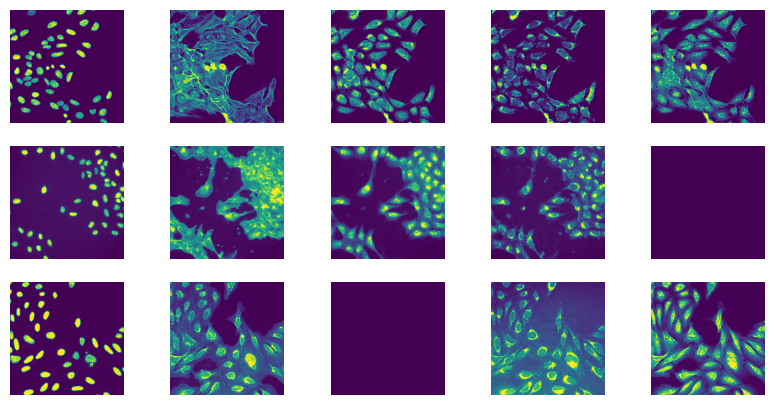

In [14]:
fig, axs = plt.subplots(3, 5, figsize=(10, 5))

for i in range(3):
    for j in range(5):
        axs[i, j].imshow(b["image"][2][i][j])
        axs[i, j].axis("off")

In [21]:
ex["compound"]

Graph(num_nodes=13, num_edges=26,
      ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)})

In [22]:
dl = DataLoader(dataset, batch_size=4, shuffle=True)

In [23]:
b = next(iter(dl))

In [9]:
b["image"].shape

torch.Size([4, 3, 5, 512, 512])

In [25]:
b["compound"]

Graph(num_nodes=56, num_edges=110,
      ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)})

In [15]:
image = b["image"]

batch_size, n_views, *image_shape = image.shape
image = image.view(-1, *image_shape)
image_emb = model.image_encoder(image)  # (BatchSize * Views) x ImagesDim

image_emb = model.image_projection_head(image_emb)  # (B * V) x EmbeddingDim
image_emb = F.normalize(image_emb, dim=-1)
image_emb = image_emb.view(batch_size, n_views, -1)  # B x V x EmbeddingDim

In [19]:
image_emb.shape

torch.Size([4, 3, 1024])

In [16]:
compound = b["compound"]

In [17]:
compound_emb = model.molecule_encoder(compound)  # B x CompoundDim
compound_emb = model.molecule_projection_head(compound_emb)  # B x E
compound_emb = F.normalize(compound_emb, dim=-1)

In [18]:
compound_emb.shape

torch.Size([4, 1024])

In [49]:
loss = NTXentMultiplePositives(
    norm=False,
    temperature=0.1,
    return_rank=True,
    eps=1e-6,
)

In [51]:
loss(image_emb, compound_emb)

tensor(2.4273, grad_fn=<NegBackward0>)

In [39]:
kl_loss = KLDivergenceMultiplePositives(
    norm=False,
    temperature=0.1,
    return_rank=True,
)

In [41]:
kl_loss(image_emb, kl_comp)

tensor(nan, grad_fn=<NegBackward0>)

In [21]:
mu_fc = nn.Linear(out_dim := compound_emb.shape[-1], out_dim)
sigma_fc = nn.Linear(out_dim, out_dim)

In [22]:
kl_comp = torch.stack([mu_fc(compound_emb), sigma_fc(compound_emb)], dim=1)

In [ ]:
kl_comp.shape

torch.Size([12, 2, 1024])

In [ ]:
image_emb.shape

torch.Size([1024])

In [51]:
z1, z2 = kl_comp, image_emb

z1_means = z1[:, 0, :]  # [batch_size, metric_dim]
z1_stds = torch.exp(z1[:, 1, :])  # [batch_size, metric_dim]

z2_means = z2.mean(1)  # [batch_size, metric_dim]
z2_stds = z2.std(1)  # [batch_size, metric_dim]

kl_div_kernel = []
for i, z1_mean in enumerate(z1_means):  # batch_size
    for j, z2_mean in enumerate(z2_means):  # batch_size
        z1_std = z1_stds[i]  # [metric_dim]
        z2_std = z2_stds[j] + 1e-5  # [metric_dim]
        p = torch.distributions.MultivariateNormal(z1_mean, torch.diag_embed(z1_std))
        q = torch.distributions.MultivariateNormal(z2_mean, torch.diag_embed(z2_std))
        kl_divergence = torch.distributions.kl_divergence(p, q)
        kl_div_kernel.append(kl_divergence)


kl_div_kernel = torch.stack(kl_div_kernel)
kl_div_kernel = kl_div_kernel.view(batch_size, batch_size)
sim_matrix = torch.nan_to_num(torch.exp(kl_div_kernel / 0.1))  # [batch_size, batch_size]
pos_sim = torch.diagonal(sim_matrix)
loss = pos_sim / (sim_matrix.sum(dim=1) - pos_sim)
loss = -torch.log(loss).mean()

In [54]:
likelihood_kernel = []
for i, z1_mean in enumerate(z1_means):
    z1_std = z1_stds[i]  # [metric_dim]
    p = torch.distributions.Normal(z1_mean, z1_std)
    for j, z2_elem in enumerate(z2):
        z2_elem = z2_elem  # [num_conformers, metric_dim]
        prob = torch.exp(p.log_prob(z2_elem))
        likelihood_kernel.append(prob.mean())
likelihood_kernel = torch.stack(likelihood_kernel)
likelihood_kernel = likelihood_kernel.view(batch_size, batch_size)

sim_matrix = torch.exp(likelihood_kernel / 0.1)  # [batch_size, batch_size]
pos_sim = torch.diagonal(sim_matrix)
loss = pos_sim / (sim_matrix.sum(dim=1) - pos_sim)
loss = -torch.log(loss).mean()

In [59]:
z2_elem.shape

torch.Size([3, 1024])

In [55]:
loss

tensor(1.0986, grad_fn=<NegBackward0>)

In [52]:
loss

tensor(inf, grad_fn=<NegBackward0>)

In [34]:
z1, z2 = kl_comp, image_emb

z1_means = z1[:, 0, :]  # [batch_size, metric_dim]
z1_stds = torch.exp(z1[:, 1, :])  # [batch_size, metric_dim]

z2_means = z2.mean(1)  # [batch_size, metric_dim]
z2_stds = z2.std(1)  # [batch_size, metric_dim]

kl_div_kernel1 = []
for i, z1_mean in enumerate(z1_means):  # batch_size
    for j, z2_mean in enumerate(z2_means):  # batch_size
        z1_std = z1_stds[i]  # [metric_dim]
        z2_std = z2_stds[j] + 1e-5  # [metric_dim]
        p = torch.distributions.Normal(z1_mean, z1_std)
        q = torch.distributions.Normal(z2_mean, z2_std)
        kl_divergence = torch.distributions.kl_divergence(p, q)
        kl_div_kernel1.append(kl_divergence)


kl_div_kernel1 = torch.stack(kl_div_kernel1)

In [38]:
kl_div_kernel1.mean(1)

tensor([11282.6152, 25536.2773, 13061.1279, 11551.3105, 11181.4385, 25413.1406,
        13027.8828, 11633.3809, 11174.6953, 25636.6309, 12958.8291, 11757.7422,
        11286.6016, 25666.5137, 12989.0234, 11652.1758],
       grad_fn=<MeanBackward1>)

In [70]:
torch.distributions.kl_divergence(p, q)

tensor([ 1119.1931,   862.0065, 69943.8750,  ..., 81272.8750,  1454.3613,
         4240.2441], grad_fn=<MulBackward0>)

In [79]:
z2_means.shape, z2_vars.shape, z1_means.shape, z1_vars.shape, torch.diag_embed(z1_vars).shape

(torch.Size([12, 1024]),
 torch.Size([12, 1024]),
 torch.Size([12, 1024]),
 torch.Size([12, 1024]),
 torch.Size([12, 1024, 1024]))

In [81]:
MultivariateNormal(z2_means, torch.diag_embed(z2_vars))

MultivariateNormal(loc: torch.Size([12, 1024]), covariance_matrix: torch.Size([12, 1024, 1024]))

In [92]:
kl_div

tensor([3787.5596, 3836.3875, 3840.8262, 4002.9888, 3790.0076, 3899.9482,
        3956.2556, 3898.6064, 3945.4016, 4095.2241, 3900.9529, 3743.7869],
       grad_fn=<AddBackward0>)

In [82]:
z1_means = z1[:, 0, :]  # [batch_size, metric_dim]
z1_vars = torch.exp(z1[:, 1, :])  # [batch_size, metric_dim]
z2_means = z2.mean(1)  # [batch_size, metric_dim]
z2_vars = z2.var(1) + 1e-6  # [batch_size, metric_dim]
try:
    normal1 = MultivariateNormal(z1_means, torch.diag_embed(z1_vars))
except:
    print(z1_vars)
try:
    normal2 = MultivariateNormal(z2_means, torch.diag_embed(z2_vars))
except:
    print(z2_vars)
# kl_div = torch.distributions.kl_divergence(normal1, normal2)
kl_div = torch.distributions.kl_divergence(normal2, normal1)
loss = kl_div.mean()

In [84]:
normal2, normal1

(MultivariateNormal(loc: torch.Size([12, 1024]), covariance_matrix: torch.Size([12, 1024, 1024])),
 MultivariateNormal(loc: torch.Size([12, 1024]), covariance_matrix: torch.Size([12, 1024, 1024])))

In [61]:
z1_mean.shape, z1_std.shape, z2_mean.shape, z2_std.shape, kl_div_kernel.shape

(torch.Size([1024]),
 torch.Size([1024]),
 torch.Size([1024]),
 torch.Size([1024]),
 torch.Size([144, 1024]))

In [63]:
torch.distributions.kl.kl_divergence?

Signature:
torch.distributions.kl.kl_divergence(
    p: torch.distributions.distribution.Distribution,
    q: torch.distributions.distribution.Distribution,
) -> torch.Tensor
Docstring:
Compute Kullback-Leibler divergence :math:`KL(p \| q)` between two distributions.

.. math::

    KL(p \| q) = \int p(x) \log\frac {p(x)} {q(x)} \,dx

Args:
    p (Distribution): A :class:`~torch.distributions.Distribution` object.
    q (Distribution): A :class:`~torch.distributions.Distribution` object.

Returns:
    Tensor: A batch of KL divergences of shape `batch_shape`.

Raises:
    NotImplementedError: If the distribution types have not been registered via
        :meth:`register_kl`.
KL divergence is currently implemented for the following distribution pairs:
    * :class:`~torch.distributions.Bernoulli` and :class:`~torch.distributions.Bernoulli`
    * :class:`~torch.distributions.Bernoulli` and :class:`~torch.distributions.Poisson`
    * :class:`~torch.distributions.Beta` and :class:`~torch.di

In [116]:
z2_means.shape

torch.Size([4, 512])

In [114]:
kl_div_kernel.shape

torch.Size([16, 512])

In [39]:
cc = dataset[21]["compound"]

In [142]:
transform = LaplacianPE(k=3)

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/dgl/transforms/module.py:507: DGLWarning: LaplacianPE will be deprecated. Use LapPE please.
  dgl_warning("LaplacianPE will be deprecated. Use LapPE please.")


In [143]:
ccc = transform(cc)

In [146]:
transform2 = SIGNDiffusion(k=3, eweight_name="gcn", in_feat_name="PE")

In [147]:
cccc = transform2(ccc)

In [137]:
ccc.ndata["PE"].shape

torch.Size([18, 3])

In [166]:
cc.ndata

{'feat': tensor([[7, 0, 1, 5, 0, 0, 1, 0, 0],
        [5, 0, 3, 5, 0, 0, 1, 0, 0],
        [7, 0, 2, 5, 1, 0, 1, 0, 0],
        [5, 0, 4, 5, 2, 0, 2, 0, 0],
        [5, 0, 4, 5, 2, 0, 2, 0, 0],
        [5, 0, 3, 5, 0, 0, 1, 0, 0],
        [7, 0, 2, 5, 1, 0, 1, 0, 0],
        [6, 0, 2, 5, 0, 0, 1, 0, 0],
        [5, 0, 3, 5, 0, 0, 1, 1, 1],
        [5, 0, 3, 5, 1, 0, 1, 1, 1],
        [5, 0, 3, 5, 1, 0, 1, 1, 1],
        [5, 0, 3, 5, 0, 0, 1, 1, 1],
        [6, 0, 3, 6, 0, 0, 1, 0, 0],
        [7, 0, 1, 5, 0, 0, 1, 0, 0],
        [7, 0, 1, 4, 0, 0, 1, 0, 0],
        [5, 0, 3, 5, 1, 0, 1, 1, 1],
        [5, 0, 3, 5, 0, 0, 1, 1, 1],
        [7, 0, 2, 5, 1, 0, 1, 0, 0]])}

In [167]:
transform3 = FeatMask(p=0.1, node_feat_names=["feat"], edge_feat_names=None)

In [168]:
c = transform3(cc)

In [172]:
transform4 = DropNode(p=0.1)

In [173]:
new_c = transform4(cc)

In [175]:
cc

Graph(num_nodes=18, num_edges=36,
      ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)})

In [174]:
new_c

Graph(num_nodes=16, num_edges=28,
      ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)})

In [63]:
def from_dgl(
    g: Any,
) -> Union["torch_geometric.data.Data", "torch_geometric.data.HeteroData"]:
    r"""Converts a :obj:`dgl` graph object to a
    :class:`torch_geometric.data.Data` or
    :class:`torch_geometric.data.HeteroData` instance.

    Args:
        g (dgl.DGLGraph): The :obj:`dgl` graph object.

    Example:

        >>> g = dgl.graph(([0, 0, 1, 5], [1, 2, 2, 0]))
        >>> g.ndata['x'] = torch.randn(g.num_nodes(), 3)
        >>> g.edata['edge_attr'] = torch.randn(g.num_edges(), 2)
        >>> data = from_dgl(g)
        >>> data
        Data(x=[6, 3], edge_attr=[4, 2], edge_index=[2, 4])

        >>> g = dgl.heterograph({
        >>> g = dgl.heterograph({
        ...     ('author', 'writes', 'paper'): ([0, 1, 1, 2, 3, 3, 4],
        ...                                     [0, 0, 1, 1, 1, 2, 2])})
        >>> g.nodes['author'].data['x'] = torch.randn(5, 3)
        >>> g.nodes['paper'].data['x'] = torch.randn(5, 3)
        >>> data = from_dgl(g)
        >>> data
        HeteroData(
        author={ x=[5, 3] },
        paper={ x=[3, 3] },
        (author, writes, paper)={ edge_index=[2, 7] }
        )
    """
    import dgl
    from torch_geometric.data import Data, HeteroData

    if not isinstance(g, dgl.DGLGraph):
        raise ValueError(f"Invalid data type (got '{type(g)}')")

    if g.is_homogeneous:
        data = Data()
        data.edge_index = torch.stack(g.edges(), dim=0)

        for attr, value in g.ndata.items():
            data[f"n_{attr}"] = value
        for attr, value in g.edata.items():
            data[f"e_{attr}"] = value

        return data

    data = HeteroData()

    for node_type in g.ntypes:
        for attr, value in g.nodes[node_type].data.items():
            data[node_type][attr] = value

    for edge_type in g.canonical_etypes:
        row, col = g.edges(form="uv", etype=edge_type)
        data[edge_type].edge_index = torch.stack([row, col], dim=0)
        for attr, value in g.edge_attr_schemes(edge_type).items():
            data[edge_type][attr] = value

    return data

In [64]:
pyg = from_dgl(cc)

In [55]:
data = Data()
data.edge_index = torch.stack(cc.edges(), dim=0)

for attr, value in cc.ndata.items():
    data[attr] = value

In [62]:
cc

Graph(num_nodes=18, num_edges=36,
      ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)})

In [68]:
pyg.keys

['n_feat', 'e_feat', 'edge_index']

In [57]:
cc.ndata.items()

ItemsView({'feat': tensor([[7, 0, 1, 5, 0, 0, 1, 0, 0],
        [5, 0, 3, 5, 0, 0, 1, 0, 0],
        [7, 0, 2, 5, 1, 0, 1, 0, 0],
        [5, 0, 4, 5, 2, 0, 2, 0, 0],
        [5, 0, 4, 5, 2, 0, 2, 0, 0],
        [5, 0, 3, 5, 0, 0, 1, 0, 0],
        [7, 0, 2, 5, 1, 0, 1, 0, 0],
        [6, 0, 2, 5, 0, 0, 1, 0, 0],
        [5, 0, 3, 5, 0, 0, 1, 1, 1],
        [5, 0, 3, 5, 1, 0, 1, 1, 1],
        [5, 0, 3, 5, 1, 0, 1, 1, 1],
        [5, 0, 3, 5, 0, 0, 1, 1, 1],
        [6, 0, 3, 6, 0, 0, 1, 0, 0],
        [7, 0, 1, 5, 0, 0, 1, 0, 0],
        [7, 0, 1, 4, 0, 0, 1, 0, 0],
        [5, 0, 3, 5, 1, 0, 1, 1, 1],
        [5, 0, 3, 5, 0, 0, 1, 1, 1],
        [7, 0, 2, 5, 1, 0, 1, 0, 0]])})

In [48]:
pyg

Data(edge_index=[2, 36], feat=[36, 3])

In [102]:
kl_loss(kl_comp, image_emb)

RuntimeError: shape '[4, 4]' is invalid for input of size 8192

## Datamodule

In [70]:
MultiviewDataModule()

Init signature:
MultiviewDataModule(
    image_metadata_path: str,
    compound_metadata_path: str,
    split_path: str,
    dataloader_config: omegaconf.dictconfig.DictConfig,
    train_ids_name: str = 'train',
    force_split: bool = False,
    compound_col: str = 'Metadata_InChI',
    transform: Optional[Callable] = None,
    compound_transform: Optional[Callable] = None,
    collate_fn: Optional[Callable] = <function default_collate at 0x7f50a9cabd00>,
    data_root_dir: Optional[str] = None,
    **kwargs,
)
Docstring:     
A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is
consistent data splits, data preparation and transforms across models.

Example::

    class MyDataModule(LightningDataModule):
        def __init__(self):
            super().__init__()
        def prepare_data(self):
            # download, split, etc...
            # only called on 1 GPU/TPU in distributed
        def setup(self, stage):
          

## Module

In [74]:
MutliviewModule?

Init signature:
MutliviewModule(
    image_encoder: torch.nn.modules.module.Module,
    molecule_encoder: torch.nn.modules.module.Module,
    criterion: torch.nn.modules.module.Module,
    optimizer: torch.optim.optimizer.Optimizer,
    scheduler: <module 'torch.optim.lr_scheduler' from '/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torch/optim/lr_scheduler.py'>,
    embedding_dim: int,
    example_input: Optional[torch.Tensor] = None,
    example_input_path: Optional[str] = None,
    monitor: str = 'val/loss',
    interval: str = 'epoch',
    frequency: int = 1,
    lr: Optional[float] = None,
    batch_size: Optional[int] = None,
    **kwargs,
)
Docstring:      Hooks to be used in LightningModule.
File:           /mnt/2547d4d7-6732-4154-b0e1-17b0c1e0c565/Document-2/Projet2/Stage/workspace/jump_models/src/models/multiview_cl/module.py
Type:           type
Subclasses:     

## Loss